# Dynamic Experiments: Feature points

<h1>Dynamic Experiments: Feature points</h1>

<p>
<b>Quantitative Big Imaging - ETHZ: 227-0966-00L</b>
<br />
</p>
<br />
<p style="font-size:1em;">April 29, 2021</p>
<br /><br />
<p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
<p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

### Papers / Sites

- Keypoint and Corner Detection
 - Distinctive Image Features from Scale-Invariant Keypoints - https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
 - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html


# Key Points (or feature points)

- Registration using the full data set is time demaning.
- We can detect feature points in an image and use them to make a registration. 


# Identifying key points
We first focus on the detection of points. 

A [Harris corner detector](https://en.wikipedia.org/wiki/Harris_Corner_Detector) helps us here:

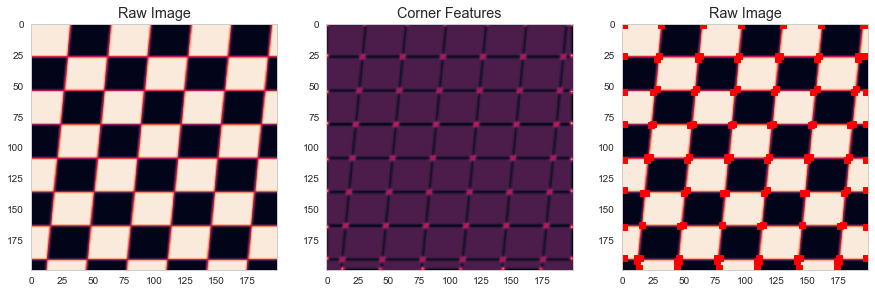

In [4]:
from skimage.feature import corner_peaks, corner_harris, BRIEF
from skimage.transform import warp, AffineTransform
from skimage import data
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
tform = AffineTransform(scale=(1.3, 1.1), rotation=0, shear=0.1,
                        translation=(0, 0))
image = warp(data.checkerboard(), tform.inverse, output_shape=(200, 200))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image); ax1.set_title('Raw Image')
ax2.imshow(corner_harris(image)); ax2.set_title('Corner Features')
peak_coords = corner_peaks(corner_harris(image),threshold_rel=0)
ax3.imshow(image); ax3.set_title('Raw Image')
ax3.plot(peak_coords[:, 1], peak_coords[:, 0], 'rs');

## Let's try the corner detection on real data

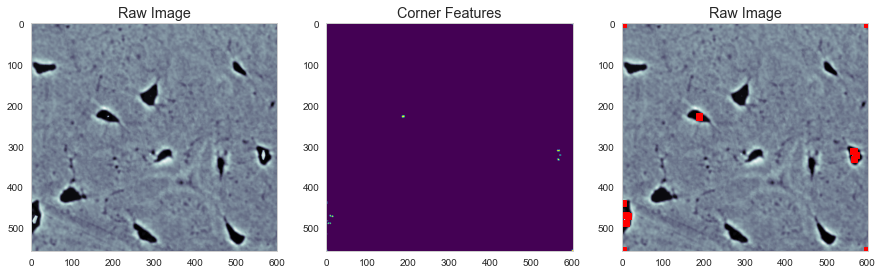

In [47]:
full_img = imread("figures/bonegfiltslice.png").mean(axis=2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(full_img,cmap='bone')
ax1.set_title('Raw Image')
ax2.imshow(2e8<corner_harris(full_img),cmap='viridis'), ax2.set_title('Corner Features')
peak_coords = corner_peaks(corner_harris(full_img),threshold_rel=0.1)

ax3.imshow(full_img,cmap='bone'), ax3.set_title('Raw Image')
ax3.plot(peak_coords[:, 1], peak_coords[:, 0], 'rs');


# Tracking with Points

__Goal:__ To reducing the tracking efforts

We can use the corner points to track features between multiple frames. 

In this sample, we see that they are 
- quite stable 
- and fixed 
    
on the features.

## We need data - a series transformed images

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)


def update_frame(i):
    c_ax.cla()
    tform = AffineTransform(scale=(1.3+i/20, 1.1-i/20), rotation=-i/10, shear=i/20,
                            translation=(0, 0))
    image = warp(data.checkerboard(), tform.inverse, output_shape=(200, 200))
    c_ax.imshow(image)
    peak_coords = corner_peaks(corner_harris(image),threshold_rel=0.1)
    c_ax.plot(peak_coords[:, 1], peak_coords[:, 0], 'rs')


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=np.linspace(0, 5, 10),
                          interval=1000,
                          repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

# Features and Descriptors
We can move beyond just key points to keypoints and feature vectors (called descriptors) at those points. 

A descriptor is a vector that describes a given keypoint uniquely. 

This will be demonstrated using two methods in the following notebook cells...


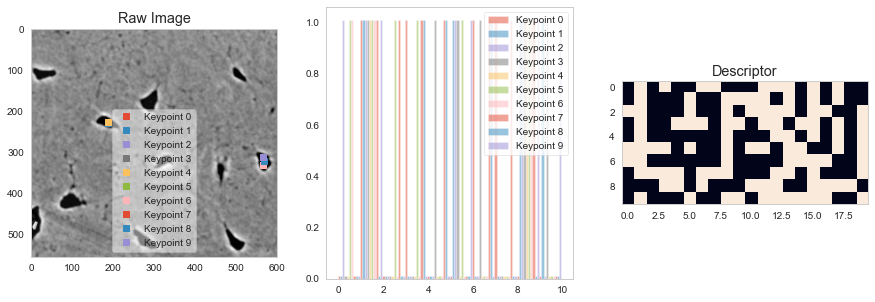

In [27]:
from skimage.feature import ORB
full_img = imread("figures/bonegfiltslice.png").mean(axis=2)
orb_det = ORB(n_keypoints=10)
det_obj = orb_det.detect_and_extract(full_img)
fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(15, 5))
ax3.imshow(full_img, cmap='gray')
ax3.set_title('Raw Image')
for i in range(orb_det.keypoints.shape[0]):
    ax3.plot(orb_det.keypoints[i, 1], orb_det.keypoints[i,
                                                        0], 's', label='Keypoint {}'.format(i))
    ax4.bar(np.arange(10)+i/10.0, orb_det.descriptors[i][:10]+1e-2, width=1/10.0,
            alpha=0.5, label='Keypoint {}'.format(i))
ax5.imshow(np.stack([x[:20] for x in orb_det.descriptors], 0))
ax5.set_title('Descriptor')
ax3.legend(facecolor='white', framealpha=0.5)
ax4.legend();

### Defining a supporting function to show the matches

In [43]:
from skimage.feature import match_descriptors, plot_matches
import matplotlib.pyplot as plt


def show_matches(img1, img2, feat1, feat2):
    matches12 = match_descriptors(
        feat1['descriptors'], feat2['descriptors'], cross_check=True)
    
    fig, (ax3, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    c_matches = match_descriptors(feat1['descriptors'],
                                  feat2['descriptors'], cross_check=True)

    plot_matches(ax3,
                 img1, img2,
                 feat1['keypoints'], feat1['keypoints'],
                 matches12)

    ax2.plot(feat1['keypoints'][:, 1],
             feat1['keypoints'][:, 0],
             '.',
             label='Before')

    ax2.plot(feat2['keypoints'][:, 1],
             feat2['keypoints'][:, 0],
             '.', label='After')

    for i, (c_idx, n_idx) in enumerate(c_matches):
        x_vec = [feat1['keypoints'][c_idx, 0], feat2['keypoints'][n_idx, 0]]
        y_vec = [feat1['keypoints'][c_idx, 1], feat2['keypoints'][n_idx, 1]]
        dist = np.sqrt(np.square(np.diff(x_vec))+np.square(np.diff(y_vec)))
        alpha = np.clip(50/dist, 0, 1)[0]

        ax2.plot(
            y_vec,
            x_vec,
            'k-',
            alpha=alpha,
            label='Match' if i == 0 else ''
        )

    ax2.legend()

    ax3.set_title(r'{} $\rightarrow$ {}'.format('Before', 'After'));

### Let's create some data

In [44]:
from skimage.filters import median
full_img = imread("figures/bonegfiltslice.png").mean(axis=2)
full_shift_img = median(
    np.roll(np.roll(full_img, -15, axis=0), 15, axis=1), np.ones((1, 3)))

bw_img    = full_img
shift_img = full_shift_img

## Features found by the BRIEF descriptor

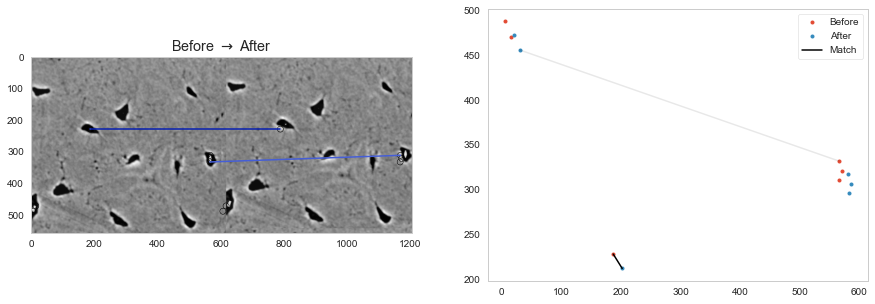

In [45]:
from skimage.feature import corner_peaks, corner_harris, BRIEF


def calc_corners(*imgs):
    b = BRIEF()
    for c_img in imgs:
        corner_img = corner_harris(c_img)
        coords = corner_peaks(corner_img, min_distance=5,threshold_rel=0.1)
        b.extract(c_img, coords)
        yield {'keypoints'  : coords,
               'descriptors': b.descriptors}


feat1, feat2 = calc_corners(bw_img, shift_img)
show_matches(bw_img, shift_img, feat1, feat2)

## Features found by the ORB descriptor

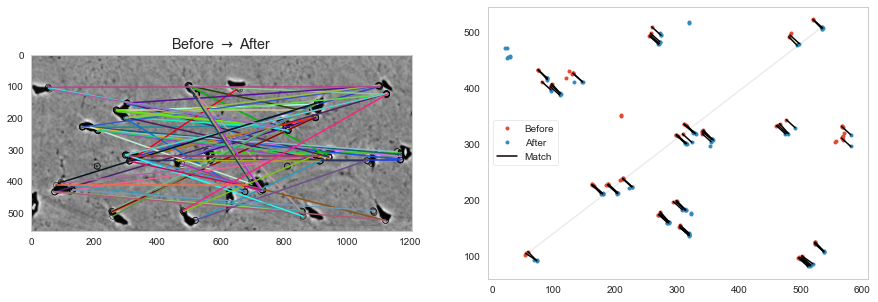

In [46]:
from skimage.feature import ORB, BRIEF, CENSURE


def calc_orb(*imgs):
    descriptor_extractor = ORB(n_keypoints=100)
    for c_img in imgs:
        descriptor_extractor.detect_and_extract(c_img)
        yield {'keypoints': descriptor_extractor.keypoints,
               'descriptors': descriptor_extractor.descriptors}


feat1, feat2 = calc_orb(bw_img, shift_img)
show_matches(bw_img, shift_img, feat1, feat2)